# Education and Earnings: Unraveling the Impact of Higher Education on Income

Written by:
- Colin Chen
- Cici Liu
- Julian Widjaja
- Thomas Farrell


## 1. Introduction

## 2. Preliminary Results

### Data Cleaning

In [1]:
library('tidyverse')
library("stringr")
options(repr.plot.width=8, repr.plot.height=6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


We downloaded the dataset from [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/2/adult) to the data folder. Now we read the data from the dataset and store it in `adult_data`.

In [2]:
adult_data <- read.table("./data/adult.data", header=FALSE, sep= ",",
                 col.names = c("age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", 
                               "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "class"))

adult_df <- as.data.frame(apply(adult_data, 2, str_remove_all, " "))

head(adult_df)
nrow(adult_df)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


[1] 32561

We need to change some variable types before progressing:

In [3]:
dt <- adult_df %>%
    mutate(above_50_k = (class == ">50K"),
          hours_per_week = as.integer(hours_per_week))

Since we are primarily interested in people who received education in schools of learning and researching, we now filter out irrelevent categories in `education`. For our purpose, we also redefine the variable to group people into three segments: people without the bachelor's degree, people with the bachelor's degree, and those who earned a master's degree.

In [4]:
data <- dt %>%
    filter(!education %in% c("Some-college", "Prof-school", "Assoc-acdm", "Assoc-voc", "Doctorate")) %>%
    mutate(education = if_else((education != "Bachelors" & education != "Masters"), "No_Bachelors", education)) %>%
    mutate(education = factor(education))

head(data)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class,above_50_k
,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<lgl>
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,FALSE
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,FALSE
3,38,Private,215646,No_Bachelors,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,FALSE
4,53,Private,234721,No_Bachelors,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,FALSE
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,FALSE
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,FALSE


### Descriptive Statistics

After data wrangling, we would like to have an insight in the demographic composition of different groups who make either more or less than 50k. These will help us make reasonable decisions in adding more filtering layers to ensure the incomes for people with different education levels are comparative. It will also deepen our understanding to the divergence between groups that might be valuable in later reasoning for the difference.

#### Sample Distribution of Hours of Working

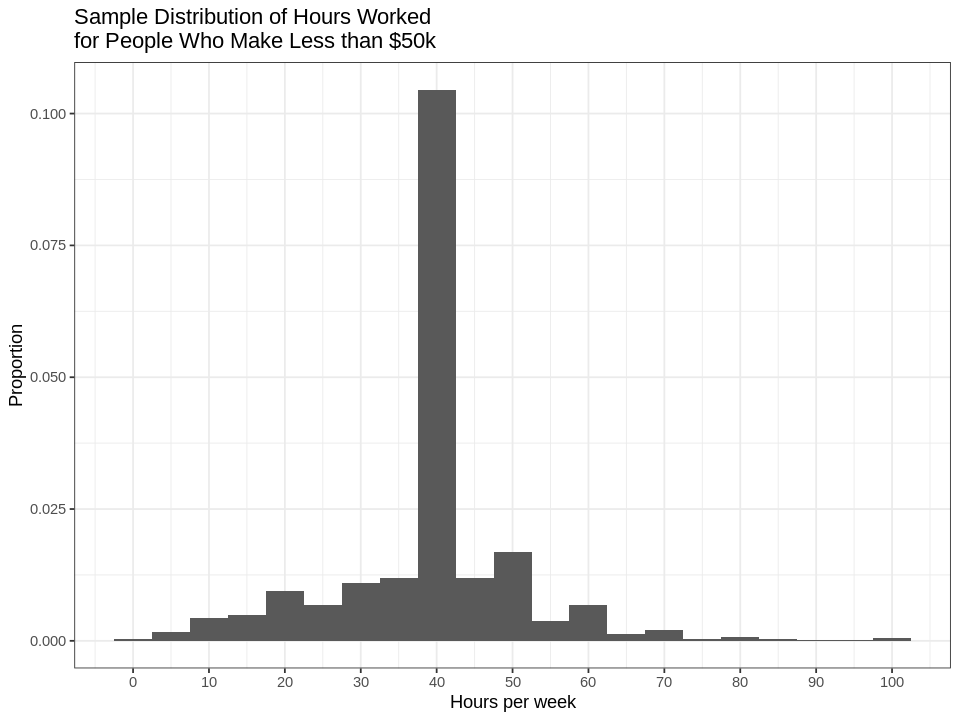

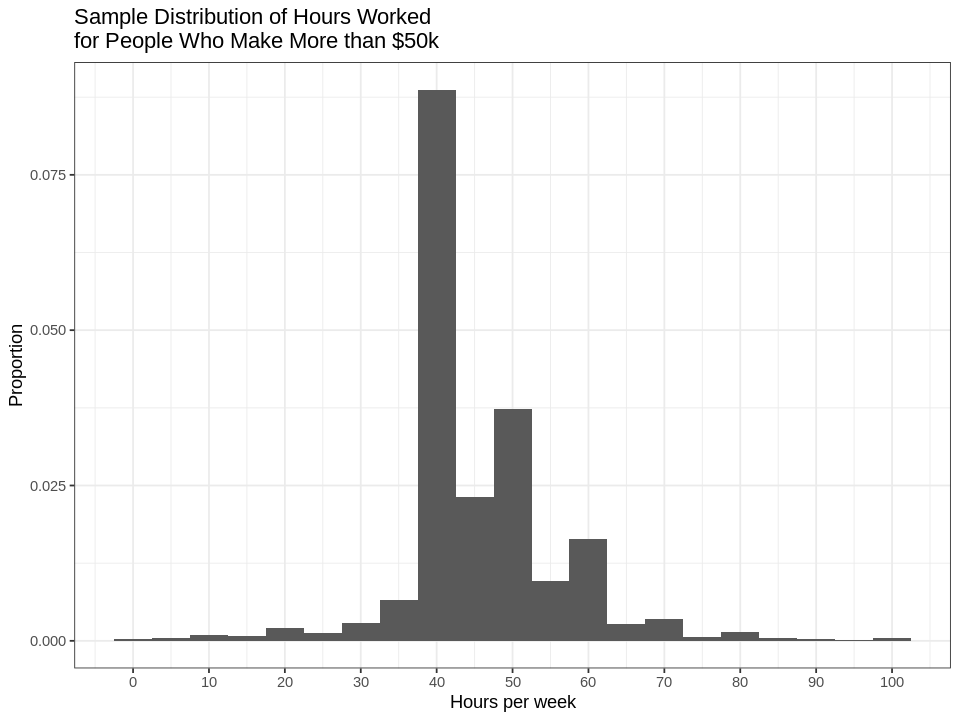

In [12]:
data %>%
    filter(above_50_k == FALSE) %>%
    ggplot() +
    geom_histogram(aes(hours_per_week, ..density..), binwidth = 5) +
    scale_x_continuous(n.breaks = 10) +
    labs(x = "Hours per week", 
         y = "Proportion",
         title = "Sample Distribution of Hours Worked \nfor People Who Make Less than $50k") +
    theme_bw()

data %>%
    filter(above_50_k == TRUE) %>%
    ggplot() +
    geom_histogram(aes(hours_per_week, ..density..), binwidth = 5) +
    scale_x_continuous(n.breaks = 10) +
    labs(x = "Hours per week",
         y = "Proportion",
         title = "Sample Distribution of Hours Worked \nfor People Who Make More than $50k") +
    theme_bw()

From the plots, we see people who make more than $50k tend to spend more hours working than their lower-income counterpart. Specifically, more data are clustered greater than 40 hours for the higher-income group, while there is higher density of data below 40 hours for the lower-income group. To disinvolve the potential confounding variable, we will focus on individuals who work for 40 hours per week.

#### Sample Distribution of Sex

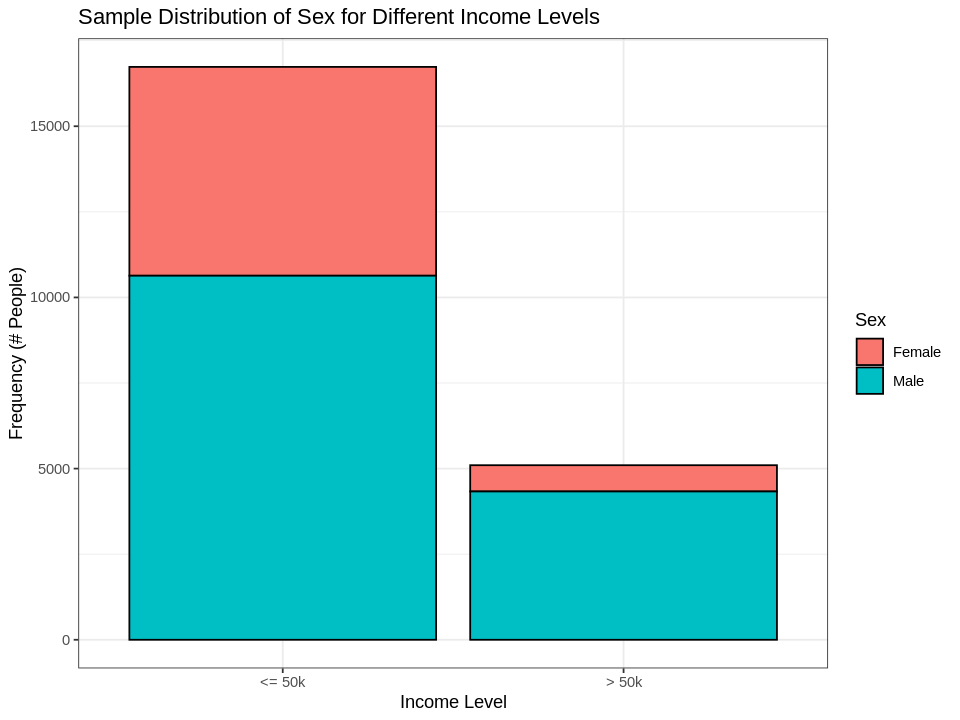

In [6]:
data %>%
    ggplot(aes(x = above_50_k)) +
    geom_bar(aes(fill = sex), position="stack", color='black') +
    scale_x_discrete(labels=c("FALSE" = "<= 50k", "TRUE" = "> 50k")) +
    # geom_text(aes(label = paste0(round((..count../sum(..count..)),2)*100, "%")),
    #         stat = "count",
    #         position = position_stack(vjust = 0.5)) +
    labs(x = "Income Level", 
         y = "Frequency (# People)",
         fill = "Sex",
         title = "Sample Distribution of Sex for Different Income Levels") +
    theme_bw()

The stacked barplot above shows that the proportion of female in the low-income group is much higher than that in the high-income group.

#### Sample Distribution of Race

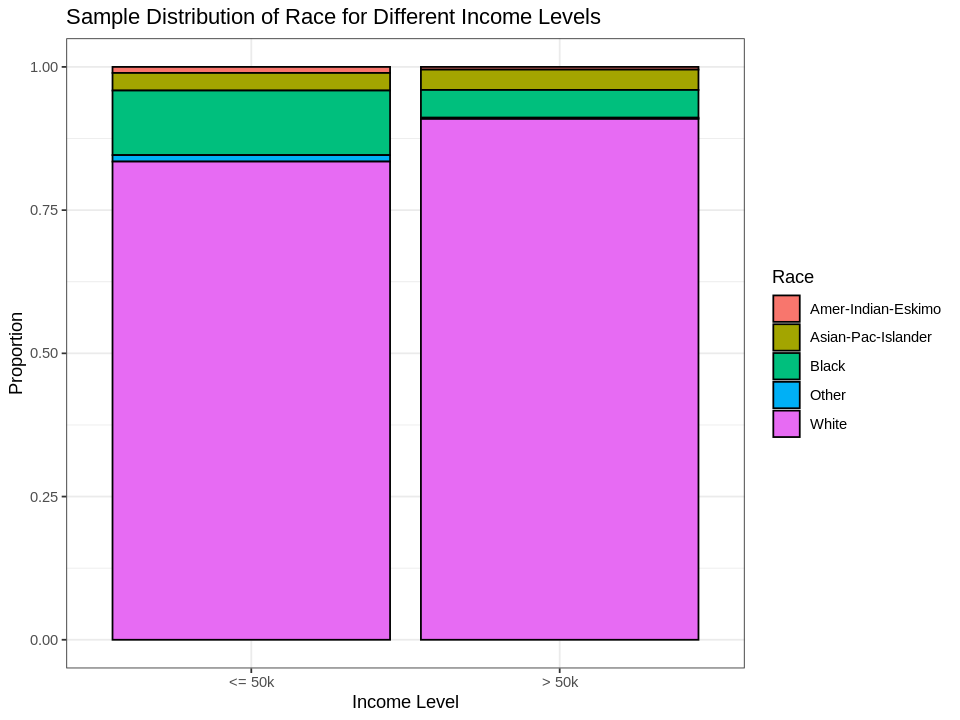

In [7]:
data %>%
    ggplot(aes(x = above_50_k)) +
    geom_bar(aes(fill = race), position="fill", color='black') +
    scale_x_discrete(labels=c("FALSE" = "<= 50k", "TRUE" = "> 50k")) +
    labs(x = "Income Level", 
         y = "Proportion",
         fill = "Race",
         title = "Sample Distribution of Race for Different Income Levels") +
    theme_bw()

The plot shows that the proportion of white people in the higher-income group is relatively higher than that in the lower-income group.

#### Paramater of Interest: Education and Income Level

The parameter of our interest is the proportion of people who make more than 50k per year with different educational level. We present them in a summary table here.

In [8]:
# 40 hours of work per week only
data_40 <- data %>%
    filter(hours_per_week == 40)

p_tbl <- data_40 %>%
    group_by(education, above_50_k) %>%
    summarize(prop = n()/nrow(data)) %>%
    group_by(education) %>%
    summarize(above_50_k = above_50_k,
              p = round(prop/sum(prop), 4))

p_tbl %>% filter(above_50_k == TRUE) %>% select(-above_50_k)

`summarise()` has grouped output by 'education'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'education'. You can override using the
`.groups` argument.


education,p
<fct>,<dbl>
Bachelors,0.3632
Masters,0.5157
No_Bachelors,0.1294


To visualize the parameter:

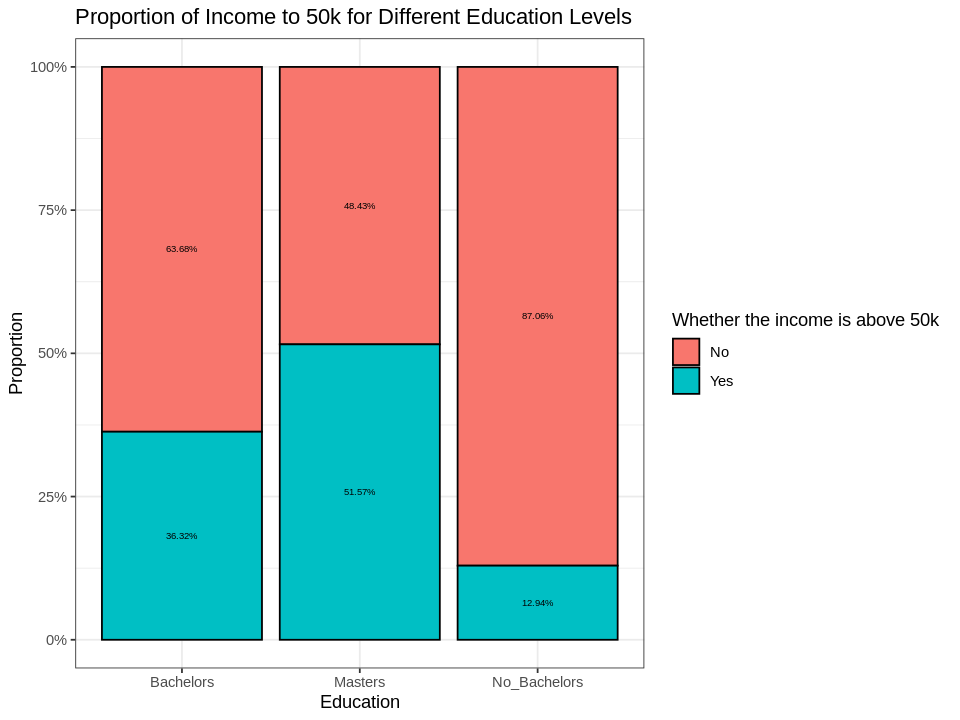

In [10]:
p_tbl %>%
  ggplot(aes(x = education, y = p, fill = above_50_k)) +
  geom_bar(position = "fill", stat = "identity", color='black', width=0.9) +
  scale_y_continuous(labels = scales::percent) +
  geom_text(aes(label = paste0(p*100,"%")), 
            position = position_stack(vjust = 0.5), size = 2) +
  labs(x = "Education",
      y = "Proportion",
      fill = "Whether the income is above 50k",
      title = "Proportion of Income to 50k for Different Education Levels") +
  scale_fill_discrete(labels=c('No', 'Yes')) +
  theme_bw()

Both from the table and the plot, we see a sharp increase in the proportion of people who make 50k or more as people gain higher educational degree. We will use the statistical inferential method to further demonstrate it.

## 3. Methods: Plan